# Предобработка датасета для обучения автоэнкодера и MLP и само обучение


Epoch 1/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 19797308.0000 - val_loss: 4080516.0000
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 2315963.5000 - val_loss: 74911.2188
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 35540.3711 - val_loss: 7494.3130
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 4699.9517 - val_loss: 1248.0465
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 959.9294 - val_loss: 445.7701
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 531.7949 - val_loss: 381.1492
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 435.7668 - val_loss: 354.8253
Epoch 8/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 608.0036 - val_loss: 343.6382
Epoch 9/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 348.5755 - val_loss: 309.7875
Epoch 10/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 306.7245 - val_loss: 302.2444
Epoch 11/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss

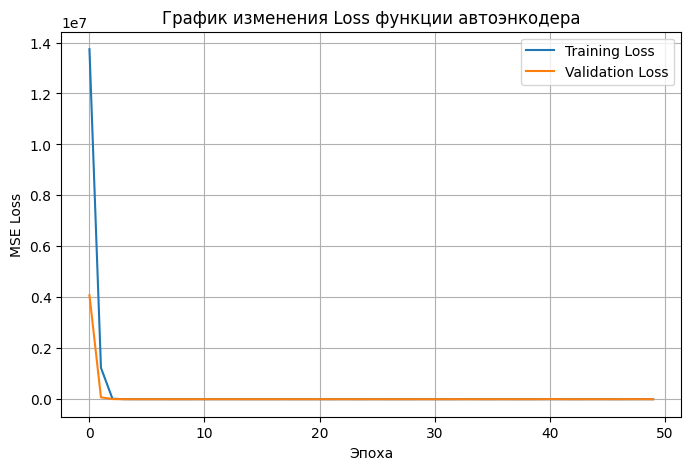

<Figure size 600x600 with 0 Axes>

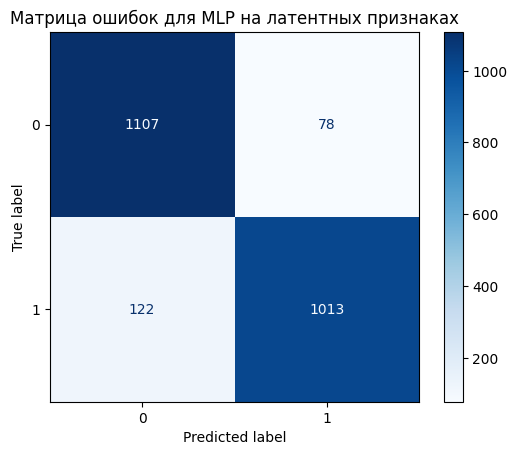

In [1]:
import pandas as pd
import hashlib
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
import tensorflow as tf


# Шаг 1: Загрузка и подготовка данных

# Загрузка датасета
df = pd.read_csv(r"D:\Проекты\Дипломаня работа\DoFitN\Code\DoFitN\Data\Data_20\combined_features.csv")

# Удаление лишних признаков: session_id и is_broadcast
df = df.drop(columns=['session_id', 'is_broadcast'])

# Функция для хеширования IP и MAC адресов
def hash_str(s, size=256):
    return int(hashlib.md5(str(s).encode()).hexdigest(), 16) % size

# Применяем хеширование
df['src_ip_hash'] = df['src_ip'].apply(lambda x: hash_str(x))
df['dst_ip_hash'] = df['dst_ip'].apply(lambda x: hash_str(x))
df['src_mac_hash'] = df['src_mac'].apply(lambda x: hash_str(x))
df['dst_mac_hash'] = df['dst_mac'].apply(lambda x: hash_str(x))

# Удаление оригинальных адресов
df = df.drop(columns=['src_ip', 'dst_ip', 'src_mac', 'dst_mac'])

# Замена бесконечностей и NaN значений на 0
df = df.replace([np.inf, -np.inf], 0)
df = df.fillna(0)

# Сохранение меток отдельно
labels = df['label'].copy()
df = df.drop(columns=['label'])

# Масштабирование признаков с помощью RobustScaler
scaler = RobustScaler()
scaled_features = scaler.fit_transform(df)

# Итоговый DataFrame нормализованных признаков
df_scaled = pd.DataFrame(scaled_features, columns=df.columns)


'''  Шаг 2: Построение и обучение автоэнкодера '''


# Размерность входных данных
input_dim = df_scaled.shape[1]

# Размерность латентного пространства
encoding_dim = 16  # Размер скрытого представления (можно варьировать)

# Определение архитектуры автоэнкодера
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(1e-5))(input_layer)
decoded = Dense(input_dim, activation='linear')(encoded)

# Автоэнкодер (сжимает и восстанавливает данные)
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Отдельная модель энкодера для получения латентного пространства
encoder = Model(inputs=input_layer, outputs=encoded)

# Компиляция автоэнкодера
autoencoder.compile(optimizer='adam', loss='mse')

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled.values, labels.values, test_size=0.2, random_state=42)

# Обучение автоэнкодера
history = autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test),
                verbose=1)


''' Шаг 3: Извлечение латентных признаков '''


# Получение скрытого представления (латентного пространства) для всех данных
latent_features = encoder.predict(df_scaled.values)

# Превращаем латентное пространство в DataFrame
latent_df = pd.DataFrame(latent_features, columns=[f'latent_{i}' for i in range(encoding_dim)])

# Добавляем метки обратно
latent_df['label'] = labels.values


''' Шаг 4: Обучение MLP на латентном пространстве '''


# Разделение латентных признаков на обучающую и тестовую выборку
X_latent = latent_df.drop(columns=['label'])
y_latent = latent_df['label']

X_latent_train, X_latent_test, y_latent_train, y_latent_test = train_test_split(
    X_latent, y_latent, test_size=0.2, random_state=42)

# Создание и обучение MLP-классификатора
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=100, random_state=42)
mlp.fit(X_latent_train, y_latent_train)

# Оценка качества классификации
accuracy = mlp.score(X_latent_test, y_latent_test)
print(f"Точность MLP на латентном пространстве: {accuracy:.4f}")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# 1. График Loss'а автоэнкодера

# Строим график
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('График изменения Loss функции автоэнкодера')
plt.xlabel('Эпоха')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()


# 2. Матрица ошибок для MLP


# Предсказания на тестовой выборке латентных признаков
y_pred = mlp.predict(X_latent_test)

# Строим confusion matrix
cm = confusion_matrix(y_latent_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Матрица ошибок для MLP на латентных признаках')
plt.grid(False)
plt.show()





Сохранение автоэнкодера и MLP обученных моделей

In [2]:
import joblib

# Сохраняем автоэнкодер
autoencoder.save('autoencoder_model.keras')

# Сохраняем MLP
joblib.dump(mlp, 'mlp_classifier.keras')

['mlp_classifier.keras']

In [8]:
print(df_scaled.columns)
joblib.dump(scaler, 'scaler.pkl')

Index(['timestamp', 'opcode', 'duplicates', 'requests', 'replies',
       'packet_rate', 'multiple_macs', 'request_reply_ratio',
       'time_since_last_packet', 'unique_ip_count', 'interval_entropy',
       'response_time', 'target_ip_diversity', 'is_gateway',
       'unanswered_requests', 'reply_percentage', 'log_packet_rate',
       'src_ip_hash', 'dst_ip_hash', 'src_mac_hash', 'dst_mac_hash'],
      dtype='object')


['scaler.pkl']